UMD Data Challenge 2021

Team 61

James Maslek
*   PHD Student - UMD/JQI

This analysis will be looking at the HUD Opportunity Zones (OZ) Dataset.  Locations are denoted in the graphic below.

![ img ]( images/Locations.png "image")

Under the 2017 Tax Cuts and Jobs Act, Governers were able to nominate up to 25% of low income census tracts to be
designated as an OZ. Designated tracts receive tax benefits meant to stimulate investments and job growth into the areas.

The main goal of this analysis is to investigate the relationship between ACS 5 year data and the classification of these OZ.

In [1]:
import pandas as pd
import us
df = pd.read_pickle('./data/AllDataMerged.pkl')
state_list = [i for i in range(1,57)]
drop_list = [3,7,14,43,52]

for drop in drop_list:

    state_list.remove(drop)
df = df[df.STATE.isin(state_list)]
#df.STATE.nunique()


In [2]:
df1 = df[df.DESIGNATED==True]
df1 = df1[['STATE','DESIGNATED']].groupby('STATE').agg('count')
df1 = df1.rename(columns={'DESIGNATED':'true'})
df2 = df[df.DESIGNATED==False]
df2 = df2[['STATE','DESIGNATED']].groupby('STATE').agg('count')
df2 = df2.rename(columns={'DESIGNATED':'false'})

df3 = df[df.DESIGNATED=='NotEligible']
df3 = df3[['STATE','DESIGNATED']].groupby('STATE').agg('count')
df3 = df3.rename(columns={'DESIGNATED':'NotEl'})

df4 = df2.merge(df1, left_index=True, right_index=True)
df4 = df4.merge(df3, left_index=True, right_index=True)

df4['state_abbr'] = [us.states.lookup(str(n).zfill(2)).abbr for n in df4.index.to_list()]
df4['total'] = df4.false + df4.true + df4.NotEl
df4['true/false'] = df4.true/df4.false
df4['true/total'] = df4.true/df4.total

Distribution of tracts.  Each state can be scrolled over to view the number of Designated, Non Designated and
Non Eligible tracts for each state.  The color is a visual representation of the ratio of Designated to Non Designated Tracts.
Most states fall into a 4:1 to 5:1 range with only Wyoming and Alaska exceeding the 2:1 rate.

For purposes of this Data Challenge, I will only be looking at the 50 US States (+DC)

In [3]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

for col in df4.columns:
    df4[col] = df4[col].astype(str)

df4['text'] = df4['state_abbr'] + '<br>' + \
    'Total: ' + df4['total'] + '<br>' + \
    'Designated: '+df4['true'] + '<br>' +\
    'NotDesignated: ' + df4['false'] + '<br>' + \
    'Not Eligible: '+df4['NotEl']

fig = go.Figure(data=go.Choropleth(
    locations=df4['state_abbr'],
    z=df4['true/false'].astype(float),
    locationmode='USA-states',
    colorscale='jet',
    autocolorscale=True,
    text=df4['text'], # hover text
    marker_line_color='white', # line markers between states
))
fig.update_layout(
    title_text = 'Ratio of Selected to Non Selected Tracts',
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
)


fig.show()

In order to get a feel for the data, I started with looking at NY state (FIPS = 36).



In [46]:
import json
ny = df[df.STATE == 36]
ny = ny[ny.DESIGNATED.notnull()]
true = ny[ny.DESIGNATED==True].shape[0]
false = ny[ny.DESIGNATED==False].shape[0]
with open('./data/variable_names.json', 'r') as fp:
    variable_translate = json.load(fp)
print(f'NY has {ny.shape[0]} tracts entered.\n'
      f'There were {true} selected and {false} not selected')
print(f'The preprocessed data has {ny.shape[1]} features')

NY has 4892 tracts entered.
There were 514 selected and 2121 not selected
The preprocessed data has 512 features


Take a look at what data is missing/null.

In [47]:
ny = ny.drop(columns=['OBJECTID', 'OBJECTID_1', 'STATE',
                          'COUNTY', 'GEOID', 'TRACT', 'NAME',
                          'CNTY_FIPS', 'EACODE', 'EANAME',
                          'GEOID_CHANGE', 'LIC', 'CROSS_STATE', 'SUBTRACTIONS',
                          'ADDITIONS', 'TRACT_TYPE', 'FID', 'STUSAB',
                          'Shape__Area', 'Shape__Length'
                          ], inplace=False)
null_cols = ny.columns[ny.isnull().sum()!=0]
print(f'There are {len(null_cols)} columns that have missing data\n\n')
for col in null_cols:
    if col in variable_translate.keys():
        print(f'{variable_translate[col]}: {ny[col].isna().sum()}')
    else:
        print(col)
many_null_cols = []
drop_frac = 0.2
n_to_drop = drop_frac * ny.shape[0]
for col in null_cols:
    count = ny[col].isna().sum()
    if count>n_to_drop :
        many_null_cols.append(col)
ny_clean = ny.drop(columns=many_null_cols, inplace=False)

There are 29 columns that have missing data


Median Year Structure Built for Renter Occupied Units: 134
Median number of rooms: 96
Median number of rooms -- Owner occupied: 224
Median number of rooms -- Renter occupied: 132
Median Contract Rent: 201
Median value -- Owner-occupied housing units: 510
Median value for units with a mortgage: 557
Median value for units without a mortgage: 636
Average Household Size of Occupied Housing Units: 79
Average Household Size of Owner occupied Housing Units: 158
Average Household Size of Renter occupied Housing Units: 94
Aggregate Travel time to work in minutes: 86
Average Travel time to Work for Workers 16 years and over who did not work at home: 27
Median Household Income In The Past 12 Months: 108
Aggregate Household Income In The Past 12 Months: 96
Median Family Income In The Past 12 Months: 119
Median Nonfamily Household Income In The Past 12 Months: 350
Population 25 years and over: 3805
Population 25 years and over having less than High Scho

Some of these variables seem like they should be important factors in distinguishing eligibility.

An example is "Median Household Income In The Past 12 Months: ", which should be among the most important factors


In order to include as much data into the modeling, we set a threshold for dropping features.  Since this will be extrapolated to
a state by state level, I will set 20% as the cutoff.  If the percentage of null values exceeds that threshold for a given state,
it will be excluded from the model.


Missing values will be imputed using `sklearn.impute.SimpleImputer(strategy='mean')`.  This replaces missing values with the
mean value of the  feature across all tracts


Data preparation.

The target variable that we wish to predict is the `DESIGNATED` column.  This can be either `True`, `False`, `NotEligible`.
I will look at modeling just the True/False categories, and I will numerically encode them as 1/0 respectively.

After removing null values over the given threshold, the inputs are taken to be all of the numeric columns.  I drop all of the geographic
and ID related features (such as GEOID - which is numeric but has no relationship to an area's designation).

Since many of the variables have two representations: a total and a percent, I will remove all of the total variables (keeping the related percent).  The reasoning
is to remove the population dependence.

The first thing to look at will be the correlation between the variables.  Here I take the 20 most correlated variables


In [48]:
import numpy as np
ny_clean = ny_clean[ny_clean.DESIGNATED != 'NotEligible'].reset_index(inplace=False)
ny_clean.DESIGNATED = (1*ny_clean.DESIGNATED).astype(int)
corrs = np.abs(ny_clean.corr()['DESIGNATED']).nlargest(21)
for i,j in zip(corrs.index[1:], corrs[1:]):
    print(f'Correlation = {j:.4f}: Variable = {i}: Name = {variable_translate[i]}')

Correlation = 0.2782: Variable = B19001_LT15_PCT: Name =     as a %  
Correlation = 0.2775: Variable = B25009EST10_PCT: Name =     as a %  
Correlation = 0.2724: Variable = B25009EST2_PCT: Name =     as a %  
Correlation = 0.2592: Variable = B17021EST2_PCT: Name = Poverty Rate
Correlation = 0.2543: Variable = B19013EST1: Name = Median Household Income In The Past 12 Months
Correlation = 0.2538: Variable = B25056_500MINUS: Name = With cash rent less than $499
Correlation = 0.2463: Variable = B19001_LT15: Name = Household Income in the Past 12 Months Less than $14,999
Correlation = 0.2304: Variable = B19113EST1: Name = Median Family Income In The Past 12 Months
Correlation = 0.2236: Variable = B25068EST13: Name = Less than $200
Correlation = 0.2232: Variable = B25106_CB_R_LT35: Name = Renter Occupied Earning Less than $35,000 paying > 30%
Correlation = 0.2177: Variable = B17019_RENT: Name = Renter occupied
Correlation = 0.2128: Variable = B17019_OWN_PCT: Name =     as a %  
Correlation =

The top three are
*   Household Income in the Past 12 Months Less than $14,999 (pct)
*   Renter Occupied (pct)
*   Owner Occupied (pct)

We can visualize the most correlated variables to see if there are any patterns in the NY data.

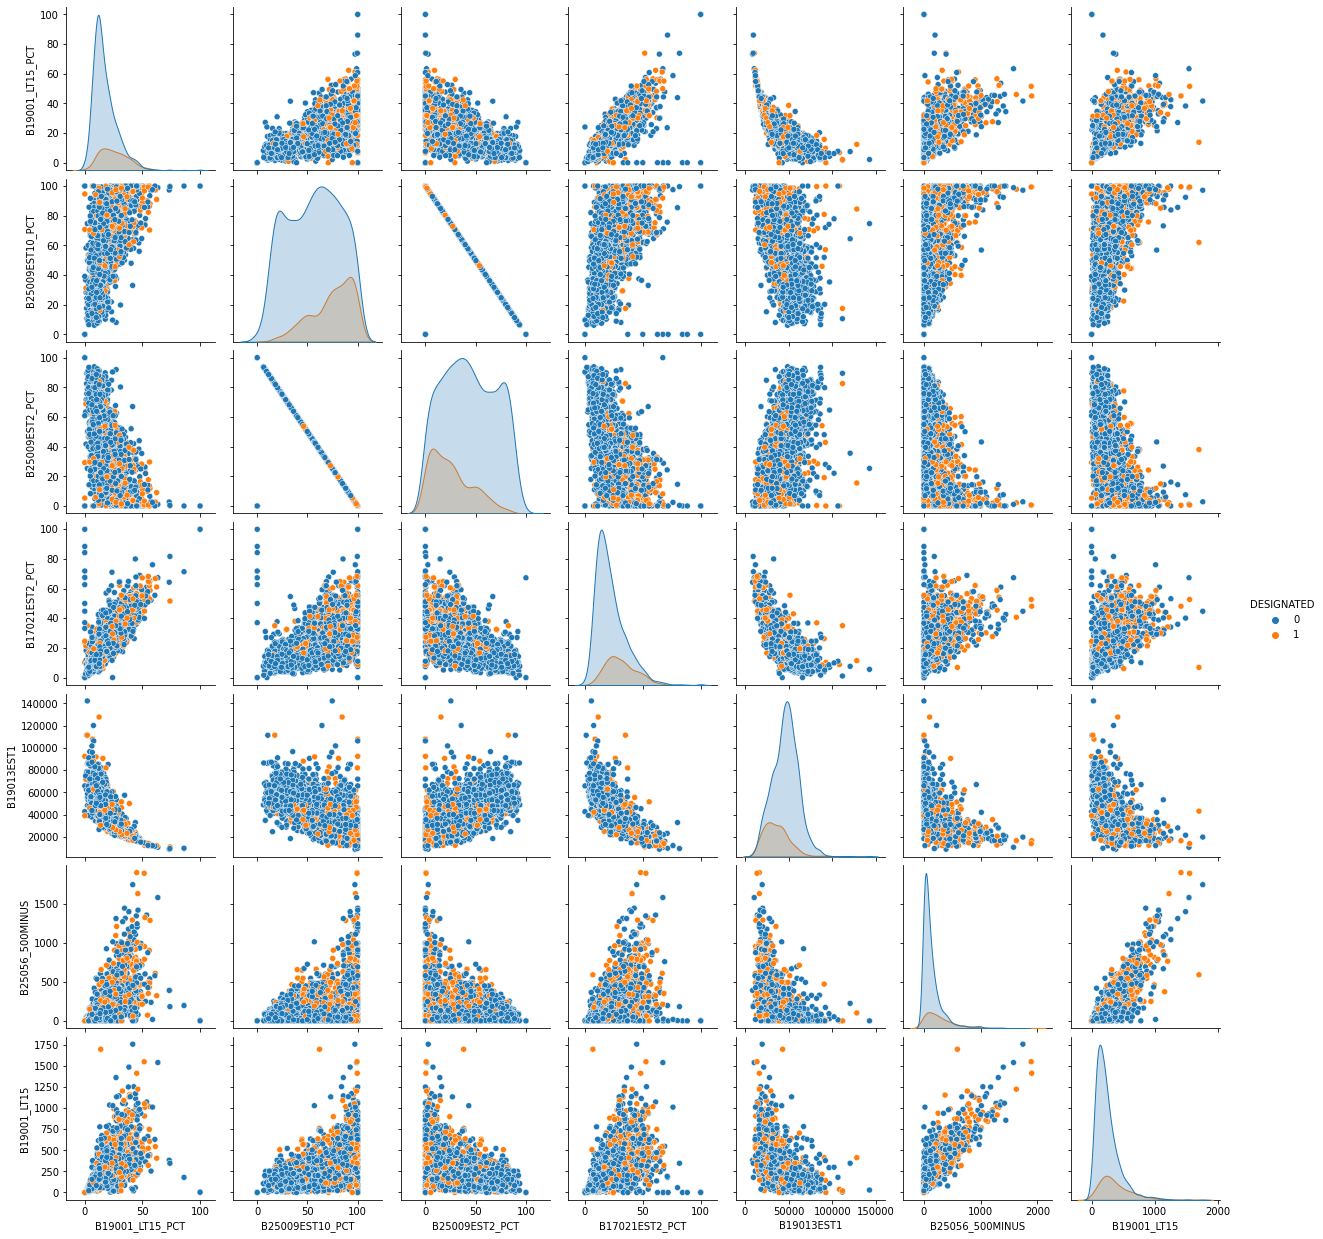

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
corrs8 = np.abs(ny_clean.corr()['DESIGNATED']).nlargest(8)

df1 = ny_clean[corrs8.index.to_list()]

sns.pairplot(df1, hue = 'DESIGNATED')
plt.show()

Model selection.

Based on the Policy Brief, which has the image below, I am interested in using Decision Trees to classify the designation.
Intuitively, a decision tree would make sense, as it would follow along with the thought process for being selected.

From a technical standpoint, the decision tree does not require any scaling, so no further preprocessing is needed.
Additionally, the sklearn library has feature_importance attributes, which measure how much information is gained by splitting a node at
the given feature.
![ img ]( images/Eligibility.png "image")


The final model that I decided on was a GradientBoostedDecisionTree.  Instead of just 1 tree, we allow the model to
learn several 'weak' trees and ensemble them.


In [49]:
#cols = [c for c in ny_clean.columns if str(c).endswith('_PCT')]
#drop_cols = [c[:-4] for c in cols if c[:-4] in ny_clean.columns]
#ny_clean = ny_clean.drop(columns = drop_cols)
#ny_clean.shape
y = ny_clean.pop('DESIGNATED')
X = ny_clean.select_dtypes(np.number)
y.loc[y == False] = 'False'
y.loc[y == True] = 'True'
y_map = {'NotEligible': -1,
         'False': 0,
         'True': 1}
y = y.map(y_map)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=340, stratify=y)
X_train = imp.fit_transform(X_train)
X_test = imp.transform(X_test)

_____________________________________________
_______ Test Classification____________
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       424
           1       0.28      0.22      0.25       103

    accuracy                           0.73       527
   macro avg       0.55      0.54      0.54       527
weighted avg       0.71      0.73      0.72       527



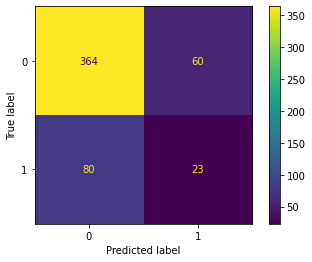

In [108]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(**{'learning_rate':.5, 'n_estimators':int(X.shape[0]/10),
             'subsample':.9,'min_samples_split':2,
             'min_samples_leaf':1,'max_depth':5,
             'random_state':32,'max_features':'sqrt',
             'verbose':0,'max_leaf_nodes':None,
             'warm_start':False,'validation_fraction':0.1,
             'n_iter_no_change':20 })
clf.fit(X_train,y_train)
print('_____________________________________________\n_______ Test Classification____________')
print(classification_report(y_test, clf.predict(X_test)))

ConfusionMatrixDisplay(confusion_matrix(y_test, clf.predict(X_test))).plot()
plt.show()

_____________________________________________
_______ Training Confusion Matrix ___________
_____________________________________________


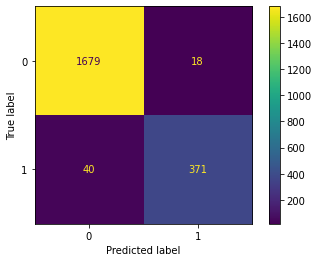

In [99]:
print('_____________________________________________\n_______ Training Confusion Matrix ___________')
print('_____________________________________________')
ConfusionMatrixDisplay(confusion_matrix(y_train, clf.predict(X_train))).plot()
plt.show()

This model is not ideal.  Since this was one of the larger states, I am trying to prevent overfitting on smaller states.

This is post hyperparameter tuning.  Adding more estimators and increasing the depth result in what seem like overfitting
on the training data, resulting in even worse test performance.  In order to generalize for smaller states, I set n_estimators to be
the number of entries/10.  In the test set, the data is split 80/20, so the accuracy of guessing just not selected is going to be 80%.
This model's ccuracy is less than 80%, so I am inclined to think that the model is learning some information.

From the fit model, we can extract the most important features

Poverty Rate
Median Household Income In The Past 12 Months
    as a %  
    as a %  
SHAPE_Area
Universe Age 65
   as a %
SHAPE_Length
    as a %  
   as a %


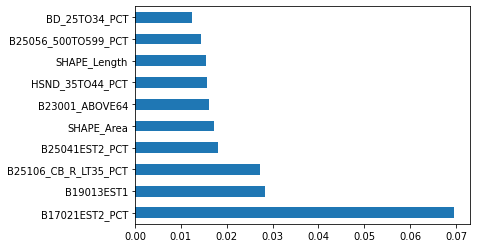

In [109]:
feature_imps = pd.Series(clf.feature_importances_, index=X.columns)
feature_imps.nlargest(10).plot(kind='barh')
m_i_f = feature_imps.nlargest(10).index
for i in m_i_f:
    if i in variable_translate.keys():
        print(variable_translate[i])
    else:
        print(i)
plt.show()

The above percentages that are listed 'as a %' are
*   Renter Occupied Earning Less than $35,000 paying > 30%
*   No bedroom
*   Population ages 35 to 44 having some High School education (No Diploma)
*   Cash rent 500 to 599
*   Population ages 25 to 34 having a Bachelor's Degree

Most of these features seem that they should have importance.  One would expect that higher poverty rates and lower median incomes
would result in a designation.  Intuitively, housing and education factors should also play a role, as they are likely enticing
for investors, but the education/housing factors appearing here seem irrelevant.

Now that the model is trained on a state level, it can be extended to each state.
For each state, a GradientBoostedClassifier is trained with n_estimators being N/10.

For each model, we record the 10 most important features in the model as well as the F1 score for the designated label on unseen
testing data.

In [122]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

def cleaned_data_model(df, STATE_ID,n_to_keep = 10, drop_pct = 0.2, to_impute = True, scale = False , **kwargs):

    df = df[df.STATE == STATE_ID].reset_index(drop=True)
    df = df[df.DESIGNATED != 'NotEligible']
    df = df.drop(columns=['OBJECTID', 'OBJECTID_1', 'STATE',
                          'COUNTY', 'GEOID', 'TRACT', 'NAME',
                          'CNTY_FIPS', 'EACODE', 'EANAME',
                          'GEOID_CHANGE', 'LIC', 'CROSS_STATE', 'SUBTRACTIONS',
                          'ADDITIONS', 'TRACT_TYPE', 'FID', 'STUSAB',
                          'Shape__Area', 'Shape__Length'
                          ], inplace=False)
    df = df.loc[df.DESIGNATED.notnull()]

    drop_count = drop_pct * df.shape[0]
    null_cols = df.columns[df.isnull().sum() != 0]
    many_null_cols = []
    for col in null_cols:
        count = df[col].isna().sum()
        if count > drop_count:
            many_null_cols.append(col)

    df_clean = df.drop(columns=many_null_cols, inplace=False)
    y = df_clean.pop('DESIGNATED')
    X = df_clean.select_dtypes(np.number)
    y.loc[y == False] = 'False'
    y.loc[y == True] = 'True'
    y_map = {'NotEligible': -1,
             'False': 0,
             'True': 1}
    y = y.map(y_map)
    cols = [c for c in X.columns if str(c).endswith('_PCT')]
    drop_cols = [c[:-4] for c in cols if c[:-4] in X.columns]
    X = X.drop(columns = drop_cols)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2)

    imp = SimpleImputer(strategy='mean')
    ss = StandardScaler()
    if to_impute:
        X_train = imp.fit_transform(X_train)
        X_test = imp.transform(X_test)
    if scale:
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

    clf = GradientBoostingClassifier( n_estimators = int(X.shape[0]/10), **kwargs )
    clf.fit(X_train, y_train)
    cr = classification_report(y_test, clf.predict(X_test), output_dict=True)
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    return feat_importances.nlargest(n_to_keep), clf.score(X_test, y_test), cr['1']['f1-score'],cr




In [149]:
df_merged = pd.read_pickle('./data/AllDataMerged.pkl')

#The CONTIGUOUS variable is actually in the dropdown image so lets make it numerical
df_merged.CONTIGUOUS = 1*(df_merged.CONTIGUOUS.fillna(0))


model_args = {'learning_rate':.5,
             'subsample':.9,'min_samples_split':2,
             'min_samples_leaf':1,'max_depth':5,
             'random_state':3,'max_features':'sqrt',
             'verbose':0,'max_leaf_nodes':None,
             'warm_start':False,'validation_fraction':0.1,
             'n_iter_no_change':20 }


# Generate a list of the 50 states + DC
state_list = [i for i in range(1,57)]
drop_list = [3,7,14,43,52]

for drop in drop_list:

    state_list.remove(drop)

# Model returns a list of n_to_keep most important features,
# classifier accuracy and True Designation f1-score
feat_dict = {}
scores = []
f1 = []
features =[]
state_names = []
for i in state_list:

    #a,b,c,d = gb_model(df_merged, i, n_to_keep=10 , **model_args)
    a,b,c,d = cleaned_data_model(df_merged, i, n_to_keep=10 , **model_args)

    feat_dict[i] = a
    features.append(a.index.to_list())
    scores.append(b)
    f1.append(c)
    state_names.append(us.states.lookup(str(i).zfill(2)).abbr)



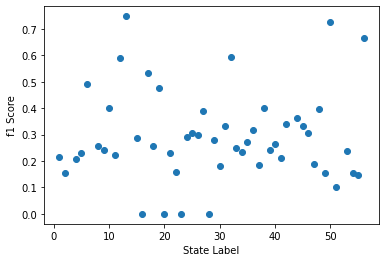

In [150]:
plt.scatter(state_list, f1)
plt.xlabel('State Label')
plt.ylabel('f1 Score')
plt.show()

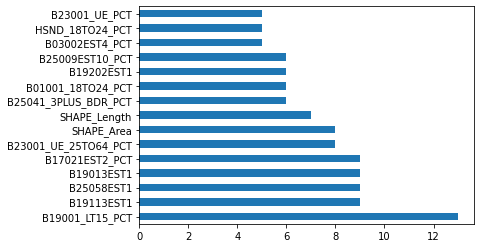

In [151]:
import itertools
from collections import Counter
total_features = list(itertools.chain(*features))
feature_counts = Counter(total_features)
counts = pd.Series(feature_counts).sort_values(ascending=True)
counts.nlargest(15).plot(kind='barh')
plt.show()

In [154]:
top_cols = counts.nlargest(7).index.to_list()
for i in counts.nlargest(7).index:
    if i in variable_translate.keys():
        print(variable_translate[i])
    else:
        print(i)

    as a %  
Median Family Income In The Past 12 Months
Median Contract Rent
Median Household Income In The Past 12 Months
Poverty Rate
25 - 65 Unemployment Rate
SHAPE_Area


Top feature

*   Household Income in the Past 12 Months Less than $14,999

In [170]:
state = []
i0 = top_cols[0]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()

In [171]:
state = []
i0 = top_cols[1]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()

In [172]:
state = []
i0 = top_cols[2]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()

In [173]:
state = []
i0 = top_cols[3]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()

In [174]:
state = []
i0 = top_cols[4]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()

In [175]:
state = []
i0 = top_cols[5]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()


In [169]:
state = []
i0 = top_cols[6]
for k,v in feat_dict.items():
    if i0 in v.index.to_list():
        state.append(us.states.lookup(str(k).zfill(2)).abbr)

fig = px.choropleth(locations=state, locationmode="USA-states",scope="usa", title=i0)
fig.show()

Takeaways:

*   Machine Learning model does not capture the patterns that lead to designation.
*   This likely indicates the fact that the OZ designation was based on more than just ACS data.  There is likely more information considered, potentially based on local trends not present in a 5 year picture.
*   In terms of modeling, some linear models, such as LinearSVC with l1 regularization did perform marginally better (f1 occasiionally exceeded .6), but the interpretation of the weights
coefficient is not as evident as the feature importances in the tree model.

Further Work:

*   Models could be more hypertuned.
*   Feature selection and engineering could be added.  Highly correlated features (such as Poverty rate with median income) could
be removed to determine if that results in better performance.
*   Feature selection was explored with recursive feature extraction, but the feature importances did not seem to change and the computation time improved.